
# Demo: training an image classifier


(Adapted from official PyTorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Initial settings

Enable plotting and import `PyTorch, Matplotlib` and `Numpy`

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## CIFAR-10 dataset

https://www.cs.toronto.edu/~kriz/cifar.html

One of the most widely used dataset for benchmarking machine learning and computer vision models.

It consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Download CIFAR-10 from `torchvision`.

In [3]:
# transform to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Have a look at few of the images



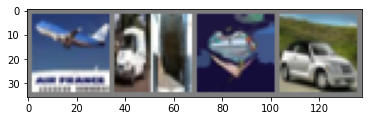

plane truck  ship   car


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Explore data to understand structure and content


In [5]:
print(f"Shape of image data: {images.shape}; shape of labels: {labels.shape}")

Shape of image data: torch.Size([4, 3, 32, 32]); shape of labels: torch.Size([4])


What do the numbers **4, 3, 32, 32** mean?

PyTorch uses the **N**umber, **C**hannel, **H**eight, **W**idth (NCHW) convention for image RGB data.

An RGB image is a 3D tensor (3d matrix):

<center>
<img src="rgb.png" alt="rgb" width="500" align="center"/>
</center>

Explore a bit more

In [6]:
print(f"Each image is: {images[0].shape}")
print(f"Example values: {images[0, 0, :5, :5]}")
print(f"Minimum and maximum vallue: ({images.min()}, {images.max()})")
print(f"Number of unique values: {torch.numel(images.unique())}")

Each image is: torch.Size([3, 32, 32])
Example values: tensor([[-0.7255, -0.7255, -0.7176, -0.7176, -0.7176],
        [-0.6863, -0.6941, -0.6941, -0.6863, -0.6941],
        [-0.6941, -0.7098, -0.7255, -0.7020, -0.6235],
        [-0.7020, -0.7333, -0.6706, -0.5294, -0.3961],
        [-0.7020, -0.5529, -0.1922, -0.2549, -0.3490]])
Minimum and maximum vallue: (-1.0, 1.0)
Number of unique values: 256


How many unique values would you expect?

Let's look at the labels

In [7]:
print(f"Labels: {labels}")

Labels: tensor([0, 9, 8, 1])


What are these numbers?

# Classification problem

Write programm which takes as input an RGB image and outputs what is in it (class).

How would you go around it?

Deep learning: define a Convolutional Neural Network (CNN)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out channels, kernel_size, stride, padding
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride=None, padding=0
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in_features, out_features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Initiate the CNN model and define the loss function and optimizer

In [9]:
net = CNN()
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Finally, train the model (optimize the parameters of the CNN).

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = lossfunc(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f"[{epoch+1}, {i+1}] loss: {running_loss / 2000}")
            running_loss = 0.0

print('Finished Training')

[1, 2000] loss: 2.234885840535164
[1, 4000] loss: 1.849354007422924
[1, 6000] loss: 1.6708052510917186
[1, 8000] loss: 1.5809183618575335
[1, 10000] loss: 1.5212142427712678
[1, 12000] loss: 1.466011063583195
[2, 2000] loss: 1.4026548552624882
[2, 4000] loss: 1.3765417374446989
[2, 6000] loss: 1.3502336562983692
[2, 8000] loss: 1.3348743485100567
[2, 10000] loss: 1.3163846985027194
[2, 12000] loss: 1.2920739700496198
Finished Training


Test the CNN model on unseen (test) data

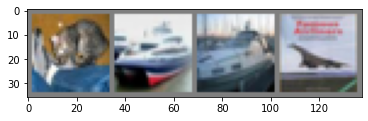

GroundTruth:    cat  ship  ship plane
Predicted:    cat truck plane plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Do the predictions match the ground truth?

Let's check overall performance

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}")

Accuracy of the network on the 10000 test images: 54.7


This is way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).



Let's check overall performance for individual classes

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
  
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is: {accuracy}")